# Bayesian Inference

In [1]:
using Distributions
using DataFrames
using Plots, Measures, StatsPlots
using Printf

# Default plot settings
gr(html_output_format=:png); # Avoid SVG and forcing PNG format for plots

## 4.1 Bayes Rule

##### Example 4.2

In [2]:
K = 0.001
or = 3
q = [ 0.64, 0.32, 0.04] # Controls are like population for a low prevalance disease
a = [1, q[2]/q[1]*or, q[3]/q[1]*or^2 ] # See GWAS 1 for for how to get case frequencies from controls and OR
f0 = 1 / sum(a) # P(X=0|D)
f = f0 * a # Case frequencies
DataFrame("cases" => f, "controls" => q)

,cases,controls
,Float64,Float64
1,0.326531,0.64
2,0.489796,0.32
3,0.183673,0.04


In [3]:
DataFrame("genotype" => 0:2, "risk" => K .* f ./ q)

,genotype,risk
,Int64,Float64
1,0,0.000510204
2,1,0.00153061
3,2,0.00459184


## 4.2 Probability model for observed GWAS data

##### Example 4.3

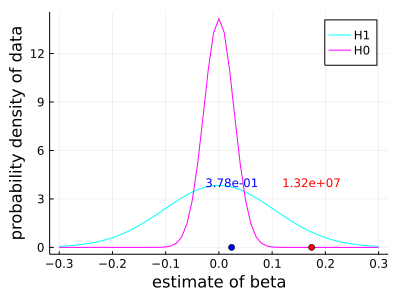

In [4]:
n = 3000 # sample size for SE calculation
f = 0.30 # MAF for SE calculation
σ = 1 # error SD
se = σ / √(2*f*(1-f)*n) # SE for QT GWAS
τ = 0.1 # prior standard deviation for effect size beta under H1

# Let's draw probablity densities of data under the two models, H0 and H1,
# as a function of MLE estimate
x = -0.30:0.01:0.30
H1 = Normal(0, √(τ^2 + se^2))
H0 = Normal(0, se)
y1 = pdf.(H1, x)
y0 = pdf.(H0, x)

fig = plot(size=(400,300), xaxis=("estimate of beta"), yaxis=("probability density of data"))
plot!(fig, x, y1, label="H1", lwd=2, lc="cyan")
plot!(fig, x, y0, label="H0", lwd=2, lc="magenta")

# We make a shortcut and don't simulate data at all, but we simulate estimates
# Suppose we have two cases, first is null, second is alternative (true betas are 0 and 0.2)
b = [ 0, 0.20]
b_est = rand.(Normal.(b, se))
scatter!(fig, b_est, zero(b_est), label=nothing, color=["blue", "red"])
# Next: log of Bayes factor of H1 vs H0, explained below
#       use log scale to avoid inaccuracies
log_bf_10 = logpdf(H1, b_est) - logpdf(H0, b_est)
bf_10 = exp.(log_bf_10)
annotate!(
    (b_est[1], 4, text(@sprintf("%.2e", bf_10[1]), 8, "blue")),
    (b_est[2], 4, text(@sprintf("%.2e", bf_10[2]), 8, "red"))
)

## 4.3 Bayes Factor

In [5]:
post_odds = @. bf_10 * 1e-6 / (1 - 1e-6) # P(H_1|D) / P(H_0|D)
post_prob = @. post_odds / (1 + post_odds) # P(H_1|D)

2-element Vector{Float64}:
 3.781696224054333e-7
 0.929635892208964

In [6]:
ccdf(Chisq(1), (b_est/se).^2)

2-element Vector{Float64}:
 0.39678732517355547
 6.342535957738673e-10

## 4.4 Approximate Bayes Factor

##### Example 4.4

In [7]:
v = 1 # Set this to phenotypic variance
p = 0.01 # effect explains less than 1% of the trait variance
target_prob = 0.95 # with this probability
maf = 0.25
# 2*maf*(1-maf)*b^2 = p*v --> b = +/- sqrt(p*v / (2*maf*(1-maf)))
b = √(p*v / (2*maf*(1-maf)))
τ_seq = 0.000:0.001:1.000 # grid to evalute tau
x = ccdf.(Normal.(0, τ_seq), b) # what is the upper tail probabilty at b for each value of tau?
τ₁ = τ_seq[argmin(abs.(x .- (1 - target_prob)/2))] # Which is closest to the target
@printf("τ₁ = %.3f has mass %.3f in (-%.4f, %.4f).", τ₁, 1 - 2*ccdf(Normal(0, τ₁), b), b, b)

τ₁ = 0.083 has mass 0.951 in (-0.1633, 0.1633).

##### Example 4.5

In [8]:
or = 1.3 # Effect is atmost this large
target_prob = 0.95 # with this probability
b = log(or)
τ_seq = 0.000:0.001:1.000 # grid to evaluate τ
x = ccdf.(Normal.(0, τ_seq), b) # what is the upper tail probability at b for each value of tau?
τ₁ = τ_seq[argmin(abs.(x .- (1 - target_prob)/2))] # which is the closest to the target
@printf("τ₁ = %.3f has mass %.3f in (-%.4f, %.4f).", τ₁, 1 - 2*ccdf(Normal(0, τ₁), b), b, b)

τ₁ = 0.134 has mass 0.950 in (-0.2624, 0.2624).